In [1]:
import numpy as np
seed = 42
np.random.seed(seed)
import pandas as pd
import os, shutil, glob, cv2, sys, argparse
from natsort import natsorted
from insectrec.utils import clean_folder, get_plate_names, export_labels, SAVE_DIR, read_plate
from tqdm import tqdm

In [2]:
datadir = '/home/kalfasyan/data/images/sticky_plates/'
years = ['2020']

In [4]:
created_data_path = f'{datadir}/created_data'

# CREATING NECESSARY DIRECTORIES FOR THE PROJECT
path_annotations = f'{created_data_path}/annotations/'
path_images = f'{created_data_path}/images/'
path_voc_annotations = f'{created_data_path}/voc_annotations/'
path_crops_export = f'{created_data_path}/crops_export/'
path_images_augmented = f'{created_data_path}/images_augmented/'
path_weights = f'{created_data_path}/weights/'
path_logs = f'{created_data_path}/logs/'
for path in [created_data_path, path_annotations, path_images, path_voc_annotations, 
			path_crops_export, path_weights, path_logs, path_images_augmented]:
	if not os.path.isdir(path):
		os.mkdir(path)	

include_herent = True
yolo_to_voc = True # In the end of the script, yolo annotations get converted to voc
extract_boxes = True # Only works if above is true. Bounding boxes extracted and saved as images
clean = True # Deleting previous data created here (i.e. except of logs and weights)
save_extractions = False # Whether to save the extracted insect crops 

if clean:
	print(f'Cleaning directories..')
	clean_folder(path_annotations)
	clean_folder(path_images)
	clean_folder(path_voc_annotations)
	os.system(f'rm -rf {path_crops_export}*')
	os.system(f'rm -rf {path_images_augmented}*')
	os.system(f'rm {created_data_path}/df_*')
	os.system(f'rm {created_data_path}/class_mapping.csv')


Cleaning directories..


In [5]:
# Get name data from the sticky plates (their names)
BASE_DATA_DIR = f"{datadir}"
assert all([y in ['2019','2020'] for y in years]), 'Wrong year given or in wrong format.'
plates = []
for y in years:
	y_plates = get_plate_names(y, base_dir=BASE_DATA_DIR)
	plates += y_plates
	print(f"Number of plates: {len(y_plates)} for year: {y}")

Number of plates: 212 for year: 2020


In [6]:
print(f"Number of ALL plates: {len(plates)}")

Number of ALL plates: 212


In [7]:
# export_labels(created_data_dir=created_data_path, years=years)
# class_map = pd.read_csv(f'{created_data_path}/class_mapping.csv')
# assert len(class_map), "Couldn't read class mapping"
# sub = class_map[['class', 'class_encoded']].drop_duplicates()
# nan_code = sub[sub['class'].isnull()]['class_encoded'].iloc[0]

In [8]:
# # Create a dataframe to save some statistics about the plates
# # such as the number of nans and number of unique insects per plate
# short_platenames = pd.Series(plates).apply(lambda x: x.split("/")[-1][:-4])
# df_stats = pd.DataFrame(columns=['nr_nans','unique_insects','annotated'], index=short_platenames)
# all_specs = []

# annotated_plates, incomplete_plates = [], []

# # Plates to ignore, since they were found to contain bad data (blurred/misclassified etc.)
# bad_plates = []
# # "['brainlal_w27_A_58_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160', 
# # 			'brainelal_8719_B_81_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
# # 			'kampen_w25_C_72_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160',
# # 			'kampen_w25_B_71_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160']"

In [9]:
labview_cols = ['Center of Mass X.1', 'Center of Mass Y.1', 'Bounding Rect Left.1',
       'Bounding Rect Top.1', 'Bounding Rect Right.1',
       'Bounding Rect Bottom.1', 'Equivalent Ellipse Major Axis.1',
       'Equivalent Ellipse Minor Axis.1', 'Area.1', 'Convex Hull Area.1',
       'Orientation.1', 'Ratio of Equivalent Ellipse Axes.1',
       'Ratio of Equivalent Rect Sides.1', 'Elongation Factor.1',
       'Compactness Factor.1', 'Heywood Circularity Factor.1', 'Type Factor.1',
       'R', 'G', 'B']

# Loop through all plates and nested loop through all insects in the plates
for p, platename in tqdm(enumerate(plates)):
    # Skip very early plates from herent that were imaged with old Canon 
    if not include_herent:
        if platename.split('/')[-1].startswith('her'):
            print("SKIPPING HERENT PLATE")
            continue
    if platename.split('/')[-1][:-4] in bad_plates:
        print("SKIPPING BAD PLATE")
        continue

    # Defining the platename
    pname = platename.split('/')[-1][:-4] 
    if 'empty' in pname:
        continue

    # Reading the plate image (converting BGR -> RGB)
    plate_img = read_plate(platename) 
    H,W,_ = plate_img.shape

    # Reading the specifications of the plate
    spec = pd.read_csv(plates[p][:-4] + '.txt', sep="\t") 
    # Fetching column names (only needed once)
    if p == 0: 
        columns = [ii for ii in spec.columns if ii.endswith('.1')]
        colextensions = ['index', 'name plate', 'R','G','B']
        columns.extend(colextensions) # adding extra columns
    spec = spec[columns]
    spec.rename(columns={'index': 'insect_idx'}, inplace=True)
    spec.dropna(axis=0, how='any', inplace=True)

    # ADDING YOLO AND HUMAN-READABLE ANNOTATION TO COLUMNS
    cmap = class_map[class_map['platename'] == pname].drop_duplicates(subset='idx', keep='first')
    sub_map = cmap[['idx','class_encoded']].set_index('idx')
    sub_map2 = cmap[['idx','class']].set_index('idx')
    spec['yolo_class'] = sub_map
    spec['normal_class'] = sub_map2

    # REMOVING UNWANTED CLASSES 
    spec = spec[spec.normal_class != 'st'] # removing "stuk" class
    spec = spec[spec.normal_class != 'vuil'] # removing "vuil" class
    spec = spec[spec.normal_class.apply(lambda x: '+' not in str(x))]
    # SELECTING WANTED CLASSES
    wanted_classes = ['m','v','bl','c','wmv','v(cy)','bv','sw','t']
    # ['m','v','bl','c','wmv','v(cy)']
    # ['m','v','c','wmv','v(cy)','t']
    # ['m','v','bl','c','wmv','v(cy)','bv','gaasvlieg','grv','k','kever','nl','psylloidea','sp','sst','sw','t','vlieg','weg','wnv','wswl']
    spec = spec[spec.normal_class.isin(wanted_classes)]

    # Replacing commas from labview columns with dots
    for col in labview_cols:
        spec[col] = spec[col].str.replace(",",".").astype(float)

    spec_nr_classes = spec['yolo_class'].unique().shape[0]
    condition1 = (spec_nr_classes >= 0)
    condition2 = True # (spec['yolo_class'].unique()[0] not in [nan_code, np.nan])
    condition3 = (spec['yolo_class'].isnull().sum() != spec['yolo_class'].shape[0])

    df_stats.loc[pname] = pd.Series({'nr_nans': spec[spec['yolo_class'] == nan_code].shape[0], 
                                        'unique_insects': spec['yolo_class'][spec['yolo_class'] != nan_code].unique().shape[0],
                                        'annotated': False})

    # finding the annotated plates - i.e the ones that don't have all nans in 'class'
    if condition1 and condition2 and condition3:
        print(f'\nFound annotated data for plate: {condition1 and condition2} ----> Copying plate')
        annotated_plates.append(platename)
        print(f"Platename: {platename.split('/')[-1]}")
        spec['pname'] = pname
        # Making extracted boxes squares (to avoid distortions in future resizing)
        spec['width'] = 150
        spec['height'] = 150

        # Creating specifications according to 'YOLO' format
        spec['yolo_class'].fillna(0, inplace=True)
        spec['yolo_class'] = spec['yolo_class'].astype(int)
        spec['yolo_x'] = np.abs(spec['Bounding Rect Right.1'] - np.abs(spec['Bounding Rect Left.1'] - spec['Bounding Rect Right.1']) /2) / W
        spec['yolo_y'] = np.abs(spec['Bounding Rect Bottom.1'] - np.abs(spec['Bounding Rect Top.1'] - spec['Bounding Rect Bottom.1']) /2) / H
        spec['yolo_width'] = pd.concat([spec['width'], spec['height']], axis=1).max(axis=1) / W 
        spec['yolo_height'] = pd.concat([spec['width'], spec['height']], axis=1).max(axis=1) / H

        ann_full_new = os.path.join( path_annotations , f"{pname}.txt" )
        img_full_new = os.path.join( path_images , pname ) + '.jpg'

        # SAVING IMAGES
        if not os.path.isfile( img_full_new ):
            cv2.imwrite(img_full_new, plate_img)
        # SAVING ANNOTATIONS
        if not len(spec) and not os.path.isfile( ann_full_new ):
            print('Empty file', ann_full_new)
            break
        else:#if not os.path.isfile( ann_full_new ):
            spec[['yolo_class','yolo_x','yolo_y','yolo_width','yolo_height']].to_csv(ann_full_new, sep=' ', index=False, header=False)

        df_stats.loc[pname] = pd.Series({'nr_nans': spec[spec['yolo_class'] == nan_code].shape[0], 
                                            'unique_insects': spec['yolo_class'][spec['yolo_class'] != nan_code].unique().shape[0],
                                            'annotated': True})

        all_specs.append(spec)

    else:
        incomplete_plates.append(platename)
    if p > 0 : 
        break  

# df_specs = pd.concat(all_specs, axis=0)

1it [00:00,  4.81it/s]


Found annotated data for plate: True ----> Copying plate
Platename: beauv_15_7_B_53_160_1-15 s_11_48 mm_Manual_Manual_6240 x 4160.png


1it [00:01,  1.05s/it]


In [10]:
row = spec.iloc[13]
row.normal_class

'v(cy)'

In [16]:
left  = int((row.yolo_x-row.yolo_width/2.)*W)
right = int((row.yolo_x+row.yolo_width/2.)*W)
top   = int((row.yolo_y-row.yolo_height/2.)*H)
bot   = int((row.yolo_y+row.yolo_height/2.)*H)

if left < 0: left = 0;
if(right > W-1): right = W-1;
if(top < 0): top = 0;
if(bot > H-1): bot = H-1;

print(f"left: {left}, right: {right}, top: {top}, bot: {bot}")

crop = plate_img[top:bot, left:right]
crop_plate = pname.split(' ')[0]
savepath = f"{path_impy_crops_export}/{row.normal_class}/"
os.makedirs(savepath)
cv2.imwrite(f"{savepath}/{row.pname}_{row.yolo_class}_{row.normal_class}_{row.insect_idx}.jpg", crop)

left: 1653, right: 1803, top: 906, bot: 1056


FileExistsError: [Errno 17] File exists: '/home/kalfasyan/data/images/sticky_plates//created_data/impy_crops_export//v(cy)/'

In [14]:
f'{path_impy_crops_export}/{row.normal_class}/'

'/home/kalfasyan/data/images/sticky_plates//created_data/impy_crops_export//v(cy)/'

In [13]:
# left = int(row['Bounding Rect Left.1'])
# right = int(row['Bounding Rect Right.1'])
# top = int(row['Bounding Rect Top.1'])
# bot = int(row['Bounding Rect Bottom.1'])

# print(f"left: {left}, right: {right}, top: {top}, bot: {bot}")

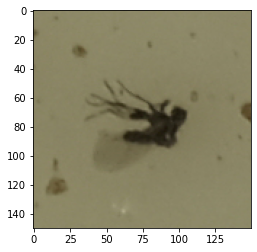

In [15]:
import matplotlib.pyplot as plt

plt.imshow(crop)